In [2]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from datetime import timedelta
import re
import paramiko
import numpy as np
pd.options.plotting.backend = "plotly"

In [3]:
def find_dir_without_graph(RESU_dir):
    date = []
    filenames = []
    dico = {}
    for filename in os.scandir(RESU_dir):
        if filename.is_dir():
            subfolder = RESU_dir.joinpath(filename.name)
            is_graph = False
            run_solver = False
            error = False
            for entry in os.scandir(subfolder):
                if entry.is_dir():
                    if re.search("Graph",entry.name):
                        is_graph = True
                if re.search("run_solver.log",entry.name):
                    run_solver = True
                if re.search("error",entry.name):
                    error = True
            if not is_graph and run_solver and not error:
                filenames.append(filename.name)
    return filenames


def preprocess_listing(res_dir,output_name='output.txt'):
    try: 
        os.mkdir(res_dir.joinpath('Graphs')) 
    except OSError as error: 
        print('Folder exists, continue')
    f = open(res_dir.joinpath("listing"),'r')
    res_dir = res_dir.joinpath('Graphs')  
    f2 = open(res_dir.joinpath(output_name),'w')
    lines = f.readlines()
    start = False
    for l in lines:
        a = re.search("v  |c  |INSTANT",l)
        if not start:
            if re.search('INSTANT',l):
                start = True
        if a and start:
            f2.write(l)
    f.close()
    f2.close()
    return res_dir.joinpath(output_name)

def extract_variable(var,filepath):
    f3 = open(filepath,'r')
    lines = f3.readlines()
    ts , content = [],[]
    for l in lines:
        a = re.search("INSTANT.*NUMBER *([0-9]*)",l)
        if a:
            ts.append(int(a.group(1)))
        b = re.search(var+' *([0-9\.eE\+-]*) *([0-9\.eE\+-]*) *([0-9\.eE\+-]*) *([0-9\.eE\+-]*) *([0-9\.eE\+-]*)',l)
        if b:
            data = []
            for g in b.groups():
                if g != '':
                    data.append(float(g))
            content.append(data)
    assert(len(ts) == len(content))
    return ts,content

def extract_fields(filepath, variables, fields):
    '''
    Extract the fields value of the specified variables
    Variables are expected to be formated like this : 
    c  var_name
    v  var_name 
    '''
    df_exist = False
    for i in range(len(variables)):
        variable = variables[i]
        col_names = []
        res = re.search('(c|v)  (\S*)',variable)
        if res:
            var_name = res.group(2)
            for var in fields:
                col_names.append((var_name,var))
            ts,content = extract_variable(variable,filepath)
            if not df_exist:
                df = pd.DataFrame(content,index=pd.Index(ts,name="Timestep"))
                df.columns = pd.MultiIndex.from_tuples(col_names)
                df_exist = True
            else:
                df1 = pd.DataFrame(content,index=pd.Index(ts,name="Timestep"))
                df1.columns = pd.MultiIndex.from_tuples(col_names)
                df = df.join(df1)
    if df_exist:
        df = df.swaplevel(axis=1)
        df = df.sort_index(axis=1)
        return df
    else:
        return None

def process_listing(RESU_dir,dir_list=None):
    temporary_file = 'output.txt'
    if dir_list == None:
        dir_list = find_dir_without_graph(RESU_dir)
    print(dir_list)
    for res in dir_list:
        result = RESU_dir.joinpath(res)
        output_path = preprocess_listing(result,temporary_file)
        resu_path = output_path.parents[0]
        value_fields = ['minimum','maximum','set_mean','spatial_mean']
        value_var = ['v  ǁVelocityǁ','v  Pressure','v  k','v  epsilon','v  CourantNb']
        conv_fields = ['Rhs norm','N_iter','Norm. residual','Drift','Time residual']
        conv_var = ['c  Velocity','c  Pressure','c  k','c  epsilon']
        df_v = extract_fields(output_path, value_var, value_fields)
        df_c = extract_fields(output_path, conv_var, conv_fields)
        with open(resu_path.joinpath('convergence_graph.html'), 'w') as f:
            for field in conv_fields:
                source_df = df_c[field].copy(deep=True)[10:]
                fig = source_df.plot(labels={"value": field+" value"})
                fig.update_layout(
                    title={'text':field, 'font':dict(size=30), 'y':0.95,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'}
                )
                f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

        with open(resu_path.joinpath('value_graph.html'), 'w') as f:
            for field in value_fields:
                source_df = df_v[field].copy(deep=True)[10:]
                fig = source_df.plot(labels={"value": field+" value"})
                fig.update_layout(
                    title={'text':field, 'font':dict(size=30), 'y':0.95,
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'}
                )
                f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
        
        k_e_path = resu_path.parents[0].joinpath('KineticEnergy.csv')
        if os.path.isfile(k_e_path):
            df = pd.read_csv(k_e_path)
            df.index = df['timestep']
            df.drop(columns='timestep',inplace=True)
            f = open(resu_path.joinpath('kinetic_energy.html'), 'w')
            fig = df.plot(labels={"value": "kinetic energy"})
            fig.update_layout(
                title={'text':'Total Kinetic Energy', 'font':dict(size=30), 'y':0.95,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'}
            )
            f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
            f.close()
        else:
            print('KineticEnergy.csv not found')


In [4]:
Doc_dir = Path("/home/juleslecoustre/Documents/FuelRod/StarMesh/RESU/")
#Study_name = "FuelRod"
#Case_Name = "CASE1"

#Case_dir = Doc_dir.joinpath(Study_name).joinpath(Case_Name)
#Res_dir = Case_dir.joinpath("RESU")
process_listing(Doc_dir,dir_list=["LR10"])

['LR10']
Folder exists, continue


In [5]:
def get_df_experiment(ExperimentDataPath):
    df_ref = pd.read_csv(ExperimentDataPath)
    col2  = []
    for col in df_ref.columns:
        col2.append(str(col).strip(' '))
    df_ref.columns = col2
    df_ref['d'] = df_ref['Y']/1000
    return df_ref


def get_measurements(df_exp,phi):
    x,y = df_exp["d"].values,df_exp["Phi{}".format(phi)].values
    x2,y2 = [],[]
    i = 0
    imax = None
    while (imax == None and i < len(x)):
        if (type(y[i]) not in [float,np.float64,np.float32] and re.search("\d",y[i]) == None):
            imax = i
        i += 1
    return x[:imax].astype(float),y[:imax].astype(float)


def process_profile(Iter_profile,Profiles_Path,phi):
    filename = "Radial{}deg_".format(phi)+Iter_profile+".csv"
    Phi_Profile_Path = Profiles_Path.joinpath(filename)

    df = pd.read_csv(Phi_Profile_Path)
    col2  = []
    for col in df.columns:
        col2.append(str(col).strip(' '))
    df.columns = col2

    d = 0.1404
    #Rod center coords
    x0 = -d
    y0 = 0
    #Rod radius
    r = 0.06
    #Angle from Ox 
    #WARNING domain between 60 and 30deg teta = 60-Phi
    teta = np.pi/180*(60-phi)

    xg = r*np.cos(teta) + x0
    yg = r*np.sin(teta) + y0

    xh = d/(3**0.5*np.tan(teta)+1) + x0
    yh = d*np.tan(teta)/(3**0.5*np.tan(teta)+1) + y0

    distanceHG = ((xh-xg)**2+(yh-yg)**2)**0.5
    df["d"] = df["s"]*distanceHG
    return df["d"].values.astype(float),df["Velocity_z"].values.astype(float)


def plot_profiles(ExperimentDataPath,Iter_profile,Profiles_Path,phi_l,Profiles_Path2=None,Iter_Path_2=None):
    df_exp = get_df_experiment(ExperimentDataPath)
    n = len(phi_l)
    width = 6
    #fig,axes = plt.subplots(n,figsize=(width,n*width))
    for i in range(n):
        plt.figure()
        phi = phi_l[i]
        x_exp,y_exp = get_measurements(df_exp,phi)
        x_cfd,y_cfd = process_profile(Iter_profile,Profiles_Path,phi)
        plt.plot(x_exp,y_exp,label="Experiment",marker='o',linestyle='--',color='b')
        plt.plot(x_cfd,y_cfd,label="Quadratic",marker='^',linestyle='--',color='r')
        if Profiles_Path2 != None:
            if Iter_Path_2 != None:
                x_cfd2,y_cfd2 = process_profile(Iter_Path_2,Profiles_Path2,phi)
            else:
                x_cfd2,y_cfd2 = process_profile(Iter_profile,Profiles_Path2,phi)
            plt.plot(x_cfd2,y_cfd2,label="RSM-SSG",marker='P',linestyle='--',color='g')
        plt.title("Phi: {}".format(phi))
        plt.xlabel("Y (mm)")
        plt.ylabel("W (m.s^-1)")
        plt.legend()

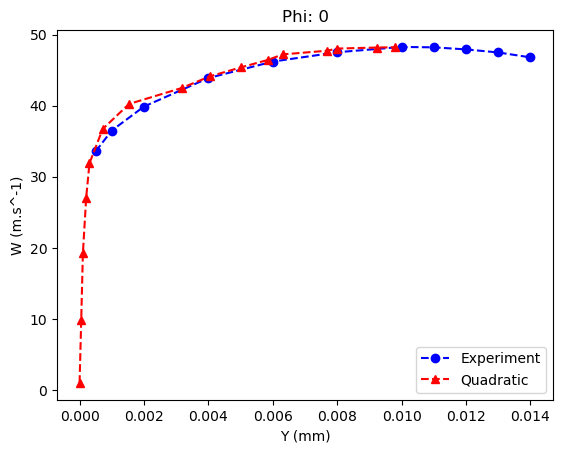

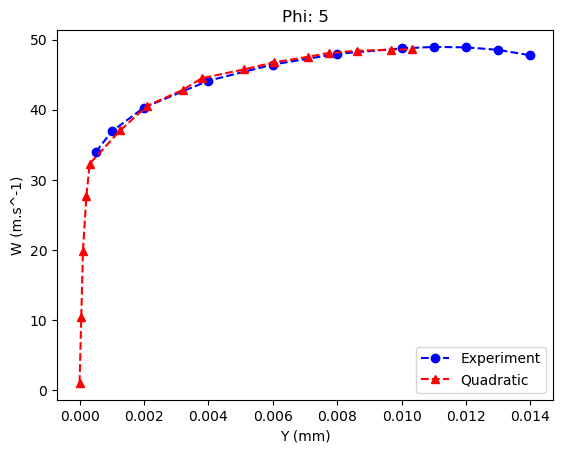

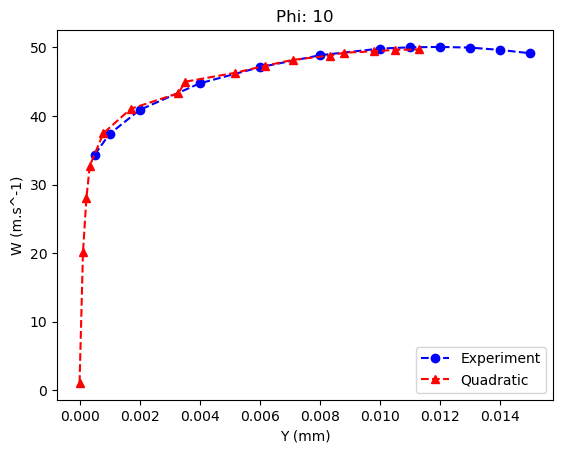

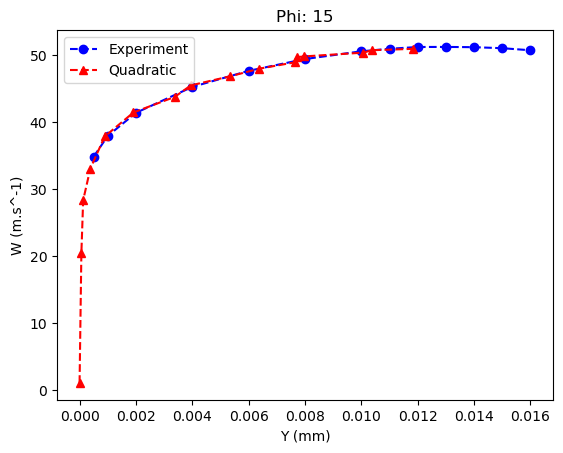

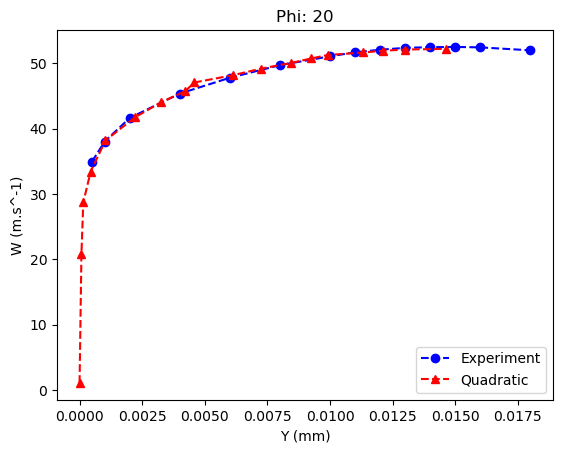

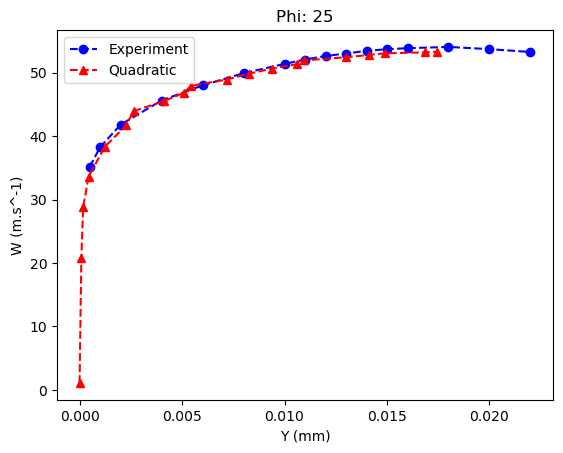

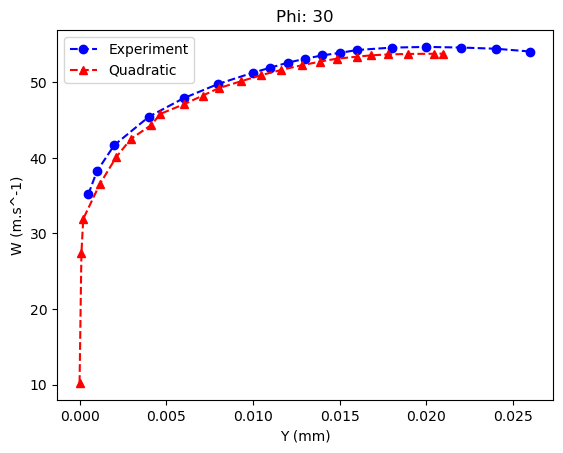

In [6]:
ExperimentDataPath = Path("/home/juleslecoustre/Documents/FuelRod/Re181200FiW.csv")
Profiles_Path = Path("/home/juleslecoustre/Documents/FuelRod/StarMesh/RESU/LR_Hexa_1/profiles")
Profiles_Path2 = Path("/media/juleslecoustre/Jules/FuelRod12Units/RESU/RSMSSG_test/profiles")

Iter_profile = "1600"
Iter_profile2 = "0800"

phi_list = [0,5,10,15,20,25,30]
plot_profiles(ExperimentDataPath,Iter_profile,Profiles_Path,phi_list)

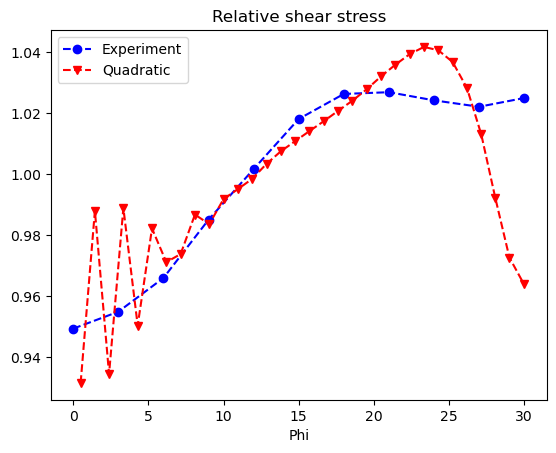

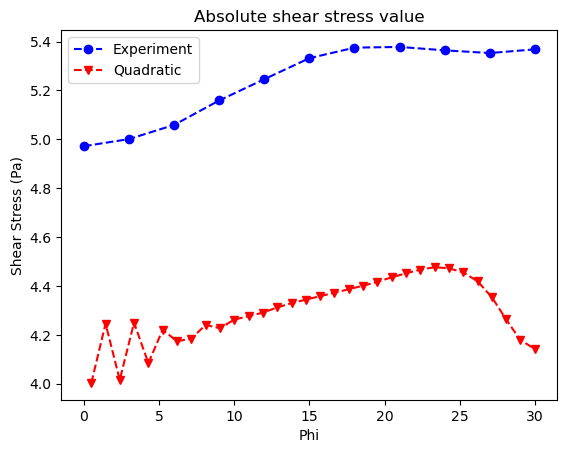

In [4]:
ExperimentDataPath_Tau = Path("/home/juleslecoustre/Documents/FuelRod/Tau.csv")
Stress_Path1 = Path("/home/juleslecoustre/Documents/FuelRod/StarMesh/RESU/LR_Hexa_1")
#Stress_Path2 = Path("/media/juleslecoustre/Jules/FuelRod12Units/RESU/RSMSSG_test")
Stress_Path2 = None

Iter_profile = "001600"
Stress1_csv_path = Stress_Path1.joinpath("Stress-{}.csv".format(Iter_profile))
if Stress_Path2 != None:
  Stress2_csv_path = Stress_Path2.joinpath("Stress-{}.csv".format(Iter_profile))


df_tau_exp = pd.read_csv(ExperimentDataPath_Tau)
df_tau_exp=df_tau_exp.astype(float)

df_stress1 = pd.read_csv(Stress1_csv_path)
df_stress1 = df_stress1.sort_values("phi",axis=0)
df_stress1["Tau_t_avg"] = df_stress1["Tau_t"]/df_stress1["Tau_t"].mean()

if Stress_Path2 != None:
  df_stress2 = pd.read_csv(Stress2_csv_path)
  df_stress2 = df_stress2.sort_values("phi",axis=0)
  df_stress2["Tau_t_avg"] = df_stress2["Tau_t"]/df_stress2["Tau_t"].mean()


fig,ax = plt.subplots()
df_tau_exp["181200_avg"] = df_tau_exp["181200"]/df_tau_exp["181200"].mean()
ax.plot(df_tau_exp["Phi"],df_tau_exp["181200_avg"],label="Experiment",marker='o',linestyle='--',color='b') 
ax.plot(df_stress1["phi"],df_stress1["Tau_t_avg"],label="Quadratic",marker='v',linestyle='--',color='r')
if Stress_Path2 != None:
  ax.plot(df_stress2["phi"],df_stress2["Tau_t_avg"],label="RSM-SSG",marker='P',linestyle='--',color='g')
ax.set_title("Relative shear stress")
ax.set_xlabel("Phi")
ax.legend() 

fig2,ax2 = plt.subplots()
ax2.plot(df_tau_exp["Phi"],df_tau_exp["181200"],label="Experiment",marker='o',linestyle='--',color='b') 
ax2.plot(df_stress1["phi"],df_stress1["Tau_t"],label="Quadratic",marker='v',linestyle='--',color='r')
if Stress_Path2 != None:
  ax2.plot(df_stress2["phi"],df_stress2["Tau_t"],label="RSM-SSG",marker='P',linestyle='--',color='g')
ax2.set_title("Absolute shear stress value")
ax2.set_xlabel("Phi")
ax2.set_ylabel("Shear Stress (Pa)")
ax2.legend() 
plt.show()



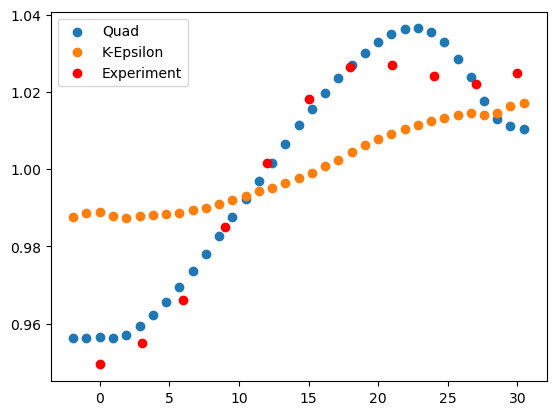

In [17]:
df_s = pd.read_csv("/home/juleslecoustre/Documents/FuelRod/StarMesh/RESU/test5.csv")[['Points_0', 'Points_1', 'Points_2','Shear_Stress_Magnitude']]
df_s = df_s.loc[df_s["Points_2"] == 5.6].copy(deep=True)
df_s["Phi"] = 60-180/np.pi*np.arctan2(df_s["Points_1"],df_s["Points_0"]+0.1404)
plt.scatter(df_s["Phi"].values,df_s["Shear_Stress_Magnitude"]/df_s["Shear_Stress_Magnitude"].mean(),label="Quad")
plt.legend()


df_s2 = pd.read_csv("/home/juleslecoustre/Documents/FuelRod/StarMesh/RESU/LS_Stress.csv")[['Points_0', 'Points_1', 'Points_2','Shear_Stress_Magnitude']]
df_s2 = df_s2.loc[df_s2["Points_2"] == 5.6].copy(deep=True)
df_s2["Phi"] = 60-180/np.pi*np.arctan2(df_s2["Points_1"],df_s2["Points_0"]+0.1404)
plt.scatter(df_s2["Phi"].values,df_s2["Shear_Stress_Magnitude"].values/df_s2["Shear_Stress_Magnitude"].mean(),label="K-Epsilon")
plt.scatter(df_tau_exp["Phi"],df_tau_exp["181200_avg"],c="r",label="Experiment") 
plt.legend()
plt.show()
plt.show()

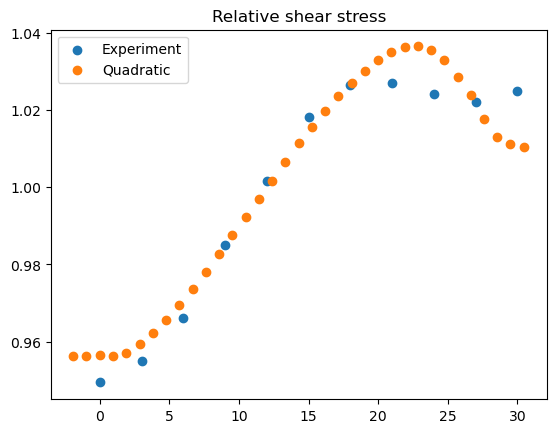

In [8]:
df_s = pd.read_csv("/home/juleslecoustre/Documents/FuelRod/StarMesh/RESU/test5.csv")[['Points_0', 'Points_1', 'Points_2','Shear_Stress_Magnitude']]
df_s = df_s.loc[df_s["Points_2"] == 5.6].copy(deep=True)
df_s["Phi"] = 180/np.pi*np.arctan2(df_s["Points_1"],df_s["Points_0"]+0.1404)
#df_s1 = df_s.loc[(df_s["Phi"] <= 30) & (df_s["Phi"] >= 0)].copy(deep=True)
#df_s2 = df_s.loc[(df_s["Phi"] >= 30) & (df_s["Phi"] <= 60)].copy(deep=True)
#df_s2["Phi"] = 60-df_s2["Phi"]
df_s["Phi"] = 60-df_s["Phi"]
plt.scatter(df_tau_exp["Phi"],df_tau_exp["181200_avg"],label="Experiment") 
plt.scatter(df_s["Phi"].values,df_s["Shear_Stress_Magnitude"].values/df_s["Shear_Stress_Magnitude"].mean(),label="Quadratic")
#plt.scatter(df_s1["Phi"].values,df_s1["Shear_Stress_Magnitude"].values/df_s1["Shear_Stress_Magnitude"].mean(),label="30-60 (original domain)")
#plt.scatter(df_s2["Phi"].values,df_s2["Shear_Stress_Magnitude"].values/df_s2["Shear_Stress_Magnitude"].mean(),label="0-30")
#plt.ylim((0.85,1.15))
plt.title("Relative shear stress")
plt.legend()
plt.show()